In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import nltk; nltk.download('stopwords')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huiwen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(["palestinianlivesmatter",
                 "israelterrorist""israelterrorists","save_sheikh_jarrah",
                   "see","go","want","yes","then","make"])

In [3]:
# Read data
df = pd.read_csv('/Users/huiwen/Documents/Side Projects/Omdena/omdena-colombia-socialnetwork/Untitled/src/data/task-3-exploratory-data-analysis/Corrected_Final_All.csv')
df.head()

,Unnamed: 0,created_at,id_str,conversation_id_str,full_text,twitter_lang,favorited,retweeted,retweet_count,favorite_count,...,preprocessed_data,emoji_list,emoticons_list,filename,data_source,lang,score,langTb,lang_langdetect,preprocessed_data_without_hashtags
0,0,2021-03-27T04:09:42+00:00,1.380000e+18,1.380000e+18,@Diputado_Canelo Hagamos otro por el uno de ma...,es,False,False,0.0,1.0,...,"['hacer', 'mayo', 'cazar', 'fantasma', 'mayo']",[''],[':/'],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['hacer', 'mayo', 'cazar', 'fantasma']"
1,1,2021-03-22T21:12:09+00:00,1.370000e+18,1.370000e+18,Después de esperar con ancias el #28F ahora es...,es,False,False,1.0,4.0,...,"['despues', 'esperar', 'ancia', 'ahora', 'espe...",['💙🤍💙'],[],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['despues', 'esperar', 'ancia', 'ahora', 'espe..."
2,2,2021-03-22T12:30:53+00:00,1.370000e+18,1.370000e+18,Espero que ésto llegue hasta oídos de la nueva...,es,False,False,0.0,1.0,...,"['esperar', 'llegar', 'oido', 'nuevo', 'inicia...",[''],[],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['esperar', 'llegar', 'oido', 'nuevo', 'inicia..."
3,3,2021-04-04T12:56:55+00:00,1.380000e+18,1.380000e+18,A menos de un mes del #1Mayo Urkullu teme perd...,es,False,False,3.0,5.0,...,"['menos', 'mes', 'mayo', 'urkullu', 'temer', '...",[''],[],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['menos', 'mes', 'urkullu', 'temer', 'perder',..."
4,4,2021-04-03T20:14:57+00:00,1.380000e+18,1.380000e+18,La X Edición del Festival Internacional Un Pue...,es,False,False,1.0,3.0,...,"['edicion', 'festival', 'internacional', 'puen...",[''],"[':/', ':/']",Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['edicion', 'festival', 'internacional', 'puen..."


In [4]:
# processed list of words to str
df['preprocessed_str_without_hashtags'] = df['preprocessed_data_without_hashtags'].apply(eval).apply(' '.join)
# df.head()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
#         print(sentence)

data = df.preprocessed_str_without_hashtags.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:2])

[['hacer', 'mayo', 'cazar', 'fantasma'], ['despues', 'esperar', 'ancia', 'ahora', 'esperar', 'despues', 'ser', 'inmagino', 'celebracion', 'ano', 'independencia', 'patria', 'ahora', 'si', 'jubil', 'ser', 'verdadero', 'libertad']]


### Bigram and Trigram Models

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, verb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:2])

[[], ['despue', 'despue', 'ser', 'celebracion', 'verdadero']]


### Date Transformation -  Corpus for needed for Topic Modelling

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])

[[], [(0, 1), (1, 2), (2, 1), (3, 1)]]


In [9]:
id2word[0]
# corpus[:1][0][:10]

'celebracion'

In [10]:
# Readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]

[[],
 [('celebracion', 1), ('despue', 2), ('ser', 1), ('verdadero', 1)],
 [('dinero', 1),
  ('iniciar', 1),
  ('joven', 1),
  ('laboral', 1),
  ('ojalar', 1),
  ('partir', 1),
  ('programa', 1),
  ('proximo', 1),
  ('ver', 1)]]

### Building Topic Model

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Print the Keyword in the 8 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.063*"colombian" + 0.022*"debt" + 0.019*"come" + 0.015*"new" + '
  '0.012*"agree" + 0.012*"uribe" + 0.010*"pay" + 0.009*"idea" + '
  '0.009*"criminal" + 0.008*"put"'),
 (1,
  '0.020*"attack" + 0.014*"link" + 0.012*"cop" + 0.010*"person" + '
  '0.009*"personal" + 0.008*"actual" + 0.008*"credit_score" + 0.007*"loan" + '
  '0.006*"opinion" + 0.006*"uribista"'),
 (2,
  '0.061*"violence" + 0.053*"mean" + 0.051*"video" + 0.045*"live" + '
  '0.033*"comment" + 0.032*"less" + 0.032*"due" + 0.025*"rule" + 0.018*"check" '
  '+ 0.011*"violent"'),
 (3,
  '0.029*"say" + 0.024*"right" + 0.023*"even" + 0.023*"thing" + 0.022*"think" '
  '+ 0.021*"many" + 0.018*"good" + 0.016*"money" + 0.014*"use" + 0.013*"bad"'),
 (4,
  '0.120*"police" + 0.039*"stop" + 0.028*"social" + 0.027*"show" + '
  '0.023*"fuck" + 0.010*"fire" + 0.008*"deficit" + 0.007*"civil" + '
  '0.006*"reason" + 0.006*"protester"'),
 (5,
  '0.171*"country" + 0.093*"kill" + 0.040*"duque" + 0.023*"real" + '
  '0.014*"pension" + 0.014*

### Compute Model Perplexity and Coherance Score

In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is, lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.984993661637873

Coherence Score:  0.4883438204702036


### Visualise Topic Keywords

In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.214975 -0.103600       1        1  23.739974
3     -0.195765 -0.083230       2        1  16.193868
0     -0.023201  0.072745       3        1  14.778959
6      0.032941  0.083057       4        1  13.119647
1      0.072772  0.077492       5        1   9.962334
4      0.004460  0.054958       6        1   9.815464
5      0.067687  0.103643       7        1   7.068257
2      0.256081 -0.205064       8        1   5.321498, topic_info=              Term         Freq        Total Category  logprob  loglift
1554       country  1296.000000  1296.000000  Default  30.0000  30.0000
4189        people  2054.000000  2054.000000  Default  29.0000  29.0000
7747        police  1266.000000  1266.000000  Default  28.0000  28.0000
1875     colombian   992.000000   992.000000  Default  27.0000  27.0000
2778          kill   707.000000   707.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
8824         early    32.905694    46.820504   Topic8  -5.1555   2.5807
8939     austerity    23.558070    31.175601   Topic8  -5.4897   2.6532
12736  credit_card    33.649880    65.195461   Topic8  -5.1331   2.2720
8884           act    30.425149   135.865922   Topic8  -5.2339   1.4370
11189         term    26.575814    92.249262   Topic8  -5.3691   1.6889

[404 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
9003      1  0.290155  abuse
9003      2  0.102408  abuse
9003      3  0.110942  abuse
9003      4  0.059738  abuse
9003      5  0.059738  abuse
...     ...       ...    ...
8610      6  0.059280  world
8610      7  0.031920  world
8610      8  0.004560  world
7016      1  0.997065  wrong
6998      2  0.996184   year

[1001 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 1, 7, 2, 5, 6, 3])

### Building LDA Mallet Model

In [15]:
# !curl http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip — output mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [16]:
## Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/huiwen/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word) # latest gensim not supported, use 3.8.3

Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 467
total tokens: 100320
<10> LL/token: -9.94728
<20> LL/token: -9.59582
<30> LL/token: -9.40485
<40> LL/token: -9.30609

0	6.25	people police protest government colombian kill amp happen protester violence thing murder state live attack bad civilian lot continue call 
1	6.25	gobierno ir persona hacer politico solo ser trabajar sector stamp venir matar lider todo duque subir millon si defender grande 
2	6.25	ver paro joven querer ser situacion hablar hacer vivo gente poder persona estar destruir mas vivir nacional post comite si 
3	6.25	poder querer vida estar hacer dictadura ver ir creer deber solo mejor todo asi apoyar please_help volver pue paro criminal 
4	6.25	country people tax shoot time good day money government pay reform year give debt tax_reform increase month city find high 
5	6.25	parte ver si pueblo gente hacer problema todo dar tener dejar asesinar narco entonce presidente corrupcion gracia acaba

<360> LL/token: -8.94749
<370> LL/token: -8.95232
<380> LL/token: -8.94383
<390> LL/token: -8.94932

0	6.25	people police colombian protest kill government amp happen protester violence shoot day stop live murder state attack civilian continue today 
1	6.25	gobierno hacer ir si politico matar problema pensar entender venir partido fuerza existir peor lider stamp subir disparar grande millon 
2	6.25	paro nacional ser persona poder ver hablar mejor situacion vivo vivir despue dinero necesitar terminar sector protesta trabajar meno esperar 
3	6.25	querer solo poder ver apoyar favor acabar igual dejar volver asi pue deber responder sacar poner siempre please_help total tocar 
4	6.25	country government people tax time good thing pay money bad lot president reform year give debt work tax_reform increase month 
5	6.25	gente todo mas ver dar parte corrupcion entonce creer quedar gracia pueblo asesinar trabajo bajo destruir pandemia tener uribismo petro 
6	6.25	duque social criminal idea world 

<710> LL/token: -8.92951
<720> LL/token: -8.92645
<730> LL/token: -8.92657
<740> LL/token: -8.92421

0	6.25	people police colombian protest kill government amp protester violence shoot day stop happen murder state attack civilian today call continue 
1	6.25	hacer gobierno ir si politico matar pensar entender venir partido fuerza problema responder stamp grande mismo peor millon propio accion 
2	6.25	poder paro nacional ser persona hablar mejor situacion vivo despue trabajar vivir dinero deber terminar sector post meno esperar protesta 
3	6.25	ver querer solo apoyar favor acabar dejar igual poder volver asi pue tocar sacar poner please_help siempre total subir ayuda 
4	6.25	country people government tax time good thing pay money bad lot president reform year give debt work increase tax_reform find 
5	6.25	gente todo mas parte corrupcion entonce gracia dar creer pueblo asesinar ciudad existir presidente destruir trabajo bajo pandemia uribismo petro 
6	6.25	duque social video criminal wor

In [17]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('police', 0.039980394902674694),
   ('people', 0.03893012183167623),
   ('protest', 0.03143817392522056),
   ('colombian', 0.028217336507491947),
   ('kill', 0.02702702702702703),
   ('government', 0.025276571908696262),
   ('amp', 0.015123932222377819),
   ('protester', 0.012603276851981515),
   ('violence', 0.012253185828315362),
   ('shoot', 0.0121131494188489)]),
 (1,
  [('hacer', 0.05957373962167251),
   ('gobierno', 0.05486604468030472),
   ('ir', 0.04219806556535136),
   ('si', 0.026020713857742017),
   ('politico', 0.017461268509800565),
   ('matar', 0.01583497389369169),
   ('quedar', 0.014294273731062228),
   ('problema', 0.01395189591714457),
   ('pensar', 0.01189762903363862),
   ('entender', 0.01095609004536506)]),
 (2,
  [('poder', 0.053504144687264506),
   ('paro', 0.03692539562923888),
   ('nacional', 0.03659047140584443),
   ('ser', 0.02972452482625806),
   ('persona', 0.02955706271456083),
   ('hablar', 0.019593067068575734),
   ('mejor', 0.017416059616511763

### Finding Optimal Number of topics for LDA

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=6)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 467
total tokens: 100320
<10> LL/token: -9.12382
<20> LL/token: -9.01819
<30> LL/token: -8.9184
<40> LL/token: -8.85039

0	25	people government police colombian protest kill country paro duque video tax amp happen protester violence shoot social time good vivo 
1	25	ver hacer poder gobierno ir querer estar gente todo vida solo persona colombio ser nacional si mas calle parte social 

<50> LL/token: -8.81882
<60> LL/token: -8.78706
<70> LL/token: -8.77531
<80> LL/token: -8.75966
<90> LL/token: -8.743

0	25	people government police colombian protest kill country duque video social tax amp happen criminal protester vivo violence shoot time good 
1	25	ver hacer gobierno poder ir querer estar vida nacional solo gente colombio paro todo ser persona joven si mas calle 

<100> LL/token: -8.7354
<110> LL/token: -8.7269
<120> LL/token: -8.72122
<130> LL/token: -8.71423
<140> LL/token: -8.70779

0	25	people government polic

1:49 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)

0	25	people government police colombian protest duque kill country video social criminal tax amp happen protester vivo violence shoot time good 
1	25	ver hacer gobierno poder ir querer estar paro nacional vida solo colombio gente todo ser persona joven si mas calle 

type: 5389 new topic: 0
1:49 
type: 3423 new topic: 1
0:48 
java.lang.ArrayIndexOutOfBoundsException: I

<160> LL/token: -9.02558
<170> LL/token: -9.0232
<180> LL/token: -9.0272
<190> LL/token: -9.01351

0	6.25	tax time good pay money state bad thing year debt work increase please_help crisis high leave point change live fuck 
1	6.25	ver gobierno querer gente mas hacer solo parte si persona ir igual problema hablar pue entender partido responder protesta apoyar 
2	6.25	estar joven calle paro amp dejar persona dictadura civil gracia vivir volver defender ser presidente destruir tocar si ver disparar 
3	6.25	duque todo vida video social criminal matar situacion gobierno favor popular sacar represion lider uribismo asesino muerte exigir grande mismo 
4	6.25	kill colombian violence shoot stop social murder vivo attack world civilian today colombia duque force protest fight demand situation control 
5	6.25	colombio nacional pueblo dar acabar corrupcion hacer paro vida desaparecido necesitar venir deber fuerza stamp masacre poner trabajo manifestacion internacional 
6	6.25	poder ir hacer ser en

<510> LL/token: -8.93495
<520> LL/token: -8.93905
<530> LL/token: -8.93732
<540> LL/token: -8.93539

0	6.25	country tax time good thing pay money bad lot year debt work increase world high leave point situation demand control 
1	6.25	ver gobierno querer gente mas si solo hacer parte hablar necesitar problema volver asi ciudad pue entender partido responder protesta 
2	6.25	estar paro nacional joven calle vivo gracia dictadura civil persona desaparecido asesinar defender ciudadano stamp presidente tocar disparar petro comite 
3	6.25	vida todo social duque criminal favor matar apoyar situacion dar popular represion vivir lider please_help uribismo asesino muerte exigir grande 
4	6.25	police kill video amp protester violence shoot colombian stop murder state attack civilian real colombia today force live fight young 
5	6.25	colombio hacer acabar corrupcion pueblo trabajar venir fuerza masacre destruir trabajo manifestacion siempre total esperar dar trave internacional meter llevar 
6	6.25

<860> LL/token: -8.91766
<870> LL/token: -8.91805
<880> LL/token: -8.91774
<890> LL/token: -8.91783

0	6.25	country tax people time good thing pay money bad world government lot reform year debt work increase high situation point 
1	6.25	ver gobierno querer hacer solo gente si mas hablar parte igual problema quedar volver pue ciudad entender dinero tocar partido 
2	6.25	estar paro nacional joven calle vivo gracia dictadura civil desaparecido asesinar defender ciudadano sacar presidente disparar despue comite millon gran 
3	6.25	vida social todo duque criminal apoyar favor matar situacion vivir dar asi popular protesta represion lider please_help uribismo muerte exigir 
4	6.25	police kill video amp protester violence shoot stop murder state attack real civilian colombia today force continue fight share young 
5	6.25	colombio pueblo acabar corrupcion trabajar fuerza narco masacre stamp dar trabajo destruir venir manifestacion siempre total esperar trave meter llevar 
6	6.25	poder ir ser 

<110> LL/token: -9.24781
<120> LL/token: -9.24699
<130> LL/token: -9.23428
<140> LL/token: -9.22015

0	3.57143	country people tax time good thing pay money bad lot year give increase month high change problem fuck poor economic 
1	3.57143	gobierno pueblo apoyar calle mas dictadura gracia responder destruir please_help siempre petro uribismo trave despue propio real share violacion solo 
2	3.57143	vida paro ir defender ciudadano gobierno social volver terminar protesta presidente bajo mismo movilizacion comite gran manifestacion ocurrir derecho hacer 
3	3.57143	government live world colombian colombia show city read point power uribe group man link military medium order love democracy back 
4	3.57143	duque social video favor ver asesinar fuerza poner represion muerte ayuda talk detener pm uribista directo publico terrorista twitter woman 
5	3.57143	police protest people kill amp government violence shoot day stop murder state civilian continue call today force attack tax_reform fight 
6

<310> LL/token: -9.11803
<320> LL/token: -9.11818
type: 129 new topic: 10
11:15 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
type: 3792 new topic: 6
7:15 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds for length 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executo

	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
type: 2776 new topic: 8
7:1158 2:1154 
java.lang.ArrayIndexOutOfBoundsException: Index 2 out of bounds for length 2
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
type: 7461 new topic: 11
9:1152 
java.lang.ArrayIndexOutOfBoundsException: Index 1 out of bounds fo

<460> LL/token: -9.10292
<470> LL/token: -9.09853
<480> LL/token: -9.10634
<490> LL/token: -9.09822

0	3.57143	country tax government time good thing pay money bad lot people debt year tax_reform increase give high point situation control 
1	3.57143	gobierno pueblo apoyar gracia dictadura venir responder destruir please_help uribismo mas pandemia mismo accion despue violacion reforma_tributario propio vandalismo suppo_add 
2	3.57143	vida social defender ciudadano todo protesta presidente terminar lider exigir necesitar movilizacion gran ocurrir bajo derecho share clase libertad trabajador 
3	3.57143	government world colombia show state leave colombian read man talk power order fuck group long uribe military link love medium 
4	3.57143	duque video favor asesinar narco poner represion esperar subir muerte ayuda trave detener pm manifestacion uribista directo terrorista plan twitter 
5	3.57143	police protest kill amp protester violence shoot day stop murder government attack civilian cont

<660> LL/token: -9.09573
<670> LL/token: -9.10121
<680> LL/token: -9.10493
<690> LL/token: -9.10075

0	3.57143	country tax thing pay money time bad good lot reform year government give debt tax_reform increase high point people problem 
1	3.57143	gobierno pueblo apoyar dictadura mas venir responder gracia please_help pandemia uribismo mismo accion violacion reforma_tributario actuar corrupto fin vandalismo suppo_add 
2	3.57143	vida social todo ciudadano presidente terminar lider bajo exigir movilizacion necesitar ocurrir derecho share protesta libertad trabajador crisis olvidar clase 
3	3.57143	government world colombia show call fight leave read man fuck talk power group colombian uribe military political link long medium 
4	3.57143	duque video favor asesinar narco represion manifestacion esperar subir trave muerte propio fuerza ayuda pm detener uribista directo publico juventud 
5	3.57143	police protest kill people amp protester violence shoot day stop murder attack civilian continue

<860> LL/token: -9.08467
<870> LL/token: -9.08574
<880> LL/token: -9.09669
<890> LL/token: -9.09381

0	3.57143	country tax time people thing pay money bad government good lot reform debt give tax_reform increase year high problem economic 
1	3.57143	gobierno pueblo apoyar gracia dictadura venir responder please_help pandemia esperar uribismo mismo accion violacion reforma_tributario actuar corrupto vandalismo suppo_add titere 
2	3.57143	vida social todo necesitar ciudadano terminar presidente lider exigir movilizacion derecho share ocurrir clase libertad trabajador olvidar proceso juventud mientra 
3	3.57143	government world call show read talk fuck power group man order long uribe link military protect guerrilla democracy comment state 
4	3.57143	duque video favor asesinar fuerza narco represion subir muerte ayuda trave propio robar detener pm uribista vivir directo terrorista twitter 
5	3.57143	police protest kill people amp protester violence shoot day murder attack government stop 

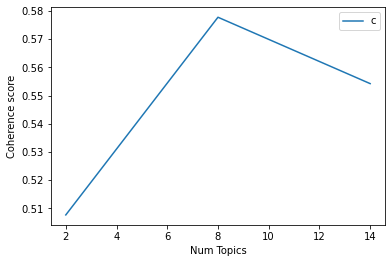

In [20]:
# Show graph
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Select the model and print the topics
optimal_model = ldamallet
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.040*"police" + 0.039*"people" + 0.031*"protest" + 0.028*"colombian" + '
  '0.027*"kill" + 0.025*"government" + 0.015*"amp" + 0.013*"protester" + '
  '0.012*"violence" + 0.012*"shoot"'),
 (1,
  '0.060*"hacer" + 0.055*"gobierno" + 0.042*"ir" + 0.026*"si" + '
  '0.017*"politico" + 0.016*"matar" + 0.014*"quedar" + 0.014*"problema" + '
  '0.012*"pensar" + 0.011*"entender"'),
 (2,
  '0.054*"poder" + 0.037*"paro" + 0.037*"nacional" + 0.030*"ser" + '
  '0.030*"persona" + 0.020*"hablar" + 0.017*"mejor" + 0.015*"vivo" + '
  '0.015*"situacion" + 0.014*"trabajar"'),
 (3,
  '0.073*"ver" + 0.042*"querer" + 0.035*"solo" + 0.019*"apoyar" + '
  '0.017*"favor" + 0.017*"acabar" + 0.014*"igual" + 0.012*"volver" + '
  '0.012*"asi" + 0.011*"pue"'),
 (4,
  '0.023*"country" + 0.022*"people" + 0.015*"tax" + 0.013*"government" + '
  '0.010*"time" + 0.010*"good" + 0.009*"thing" + 0.009*"pay" + 0.009*"money" + '
  '0.007*"bad"'),
 (5,
  '0.032*"gente" + 0.031*"todo" + 0.025*"mas" + 0.018*"dar" + 0.018*"

### Finding dominant topic in each sentence

In [22]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/Users/huiwen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/huiwen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/huiwen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/huiwen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1250,"police, people, protest, colombian, kill, gove...",hacer mayo cazar fantasma
1,1,2.0,0.1763,"poder, paro, nacional, ser, persona, hablar, m...",despues esperar ancia ahora esperar despues se...
2,2,2.0,0.1662,"poder, paro, nacional, ser, persona, hablar, m...",esperar llegar oido nuevo iniciar laboral part...
3,3,5.0,0.1603,"gente, todo, mas, dar, parte, entonce, creer, ...",menos mes urkullu temer perder control dar pas...
4,4,0.0,0.1422,"police, people, protest, colombian, kill, gove...",edicion festival internacional puente hacia ce...
5,5,0.0,0.1250,"police, people, protest, colombian, kill, gove...",cgt celebrar mayo hostigamiento sufrido empresa
6,6,5.0,0.1394,"gente, todo, mas, dar, parte, entonce, creer, ...",cgt celebrar acto central primero mayo
7,7,5.0,0.1422,"gente, todo, mas, dar, parte, entonce, creer, ...",conmemorar dia internacional trabajador ocasio...
8,8,0.0,0.1250,"police, people, protest, colombian, kill, gove...",pasado puente san jose pasado semana santo abe...
9,9,7.0,0.1633,"estar, colombio, vida, joven, calle, dictadura...",pascua resurreccion domingo posterior primero ...


In [23]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4912,"police, people, protest, colombian, kill, gove...",really sure link even find video anymore since...
1,1.0,0.3566,"hacer, gobierno, ir, si, politico, matar, qued...",ideal dectar gobierno deberir tomar mejor deci...
2,2.0,0.6824,"poder, paro, nacional, ser, persona, hablar, m...",regla general post pais sufrir grave crisis ec...
3,3.0,0.3622,"ver, querer, solo, apoyar, favor, acabar, igua...",edit sentir creer buscar tip consejo yd cualqu...
4,4.0,0.7937,"country, people, tax, government, time, good, ...",colombian taxed people pay tax nearly every co...
5,5.0,0.4321,"gente, todo, mas, dar, parte, entonce, creer, ...",creer ir ser linea principal candidato elecció...
6,6.0,0.2738,"duque, social, video, pueblo, criminal, real, ...",file republic eruptsampcauses panic among inha...
7,7.0,0.3164,"estar, colombio, vida, joven, calle, dictadura...",masacre colombio masacre colombio masacre colo...


In [24]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"police, people, protest, colombian, kill, gove...",5854.0,0.2642
1.0,2.0,"poder, paro, nacional, ser, persona, hablar, m...",3224.0,0.1455
2.0,2.0,"poder, paro, nacional, ser, persona, hablar, m...",2693.0,0.1215
3.0,5.0,"gente, todo, mas, dar, parte, entonce, creer, ...",2583.0,0.1166
4.0,0.0,"police, people, protest, colombian, kill, gove...",1357.0,0.0612
5.0,0.0,"police, people, protest, colombian, kill, gove...",2323.0,0.1048
6.0,5.0,"gente, todo, mas, dar, parte, entonce, creer, ...",1686.0,0.0761
7.0,5.0,"gente, todo, mas, dar, parte, entonce, creer, ...",2440.0,0.1101
8.0,0.0,"police, people, protest, colombian, kill, gove...",NaN,NaN
9.0,7.0,"estar, colombio, vida, joven, calle, dictadura...",NaN,NaN
